In [3]:
import json
import random
import scipy

import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from skimage import io
from skimage import filters, feature

from sklearn.utils import shuffle
from sklearn import svm

from keras.models import Sequential
import keras.layers as l

from tensorflow.keras.utils import to_categorical    


# Loading data

This code is used to load the data from the assets directory

In [4]:
images = []
bunnies = []

data = None
with open("../../Boundary_Box/coordinates.json", 'r+') as file:
    data = json.loads(file.read())
    
    for jpg in data:
        for coords in data[jpg]:
            im = io.imread(f"../../Boundary_Box/assets/{jpg}")
            x_coords = [coords['begin'][0], coords['end'][0]]
            y_coords = [coords['begin'][1], coords['end'][1]]

            images.append(im)
            bunnies.append(im[ min(y_coords) : max(y_coords) , min(x_coords) : max(x_coords) ])


# Utility functions

This code can be used as utility later on

In [5]:
def max_pooling(image, n):
    shape = image.shape
    output = np.zeros((shape[0]//n, shape[1]//n))
    
    for y in range(1, shape[1]-1, n):
        for x in range(1, shape[0]-1, n):
            region = image[x-(n//2):x+((n//2)+1), y-(n//2):y+((n//2)+1)]
            output[(x-1)//n, (y-1)//n] = region.max()

    return output

# Filters

This code is used to test if there is a different way to make some features more visible to use as patches, instead of just using black and white images.

* **Obeservations:**\
It looks like that using a smooth filter where the selected pixel weighs more than the rest, combined with a laplacian filter from the scipy library seems to really enhance subtle features.

* **Conclusion:**\
I will be using the combination of a smooth filter with a laplacian filter to extract patches and train the neural network.

In [6]:
im = images[230]
b = bunnies[230]

smooth_mean_1=[ [1/9,1/9,1/9],
              [1/9,1/9,1/9],
              [1/9,1/9,1/9]]

smooth_mean_2=[ [1/16,1/16,1/16],
              [1/16,1/5,1/16],
              [1/16,1/16,1/16]]

laplacian=[ [0.5,1,0.5],
            [1,-6,1],
            [0.5,1,0.5]]
            
laplace_im = filters.laplace(b)

smoothIMG=scipy.ndimage.convolve(b, smooth_mean_1)
laplacianIMG=scipy.ndimage.convolve(smoothIMG, laplacian)
laplacianIMG += 127

smoothIMG2=scipy.ndimage.convolve(b, smooth_mean_2)
laplacian2=scipy.ndimage.convolve(smoothIMG2, laplacian)
laplacian2 += 127

smoothIMG3=scipy.ndimage.convolve(b, smooth_mean_2)
laplacian3=filters.laplace(smoothIMG3)




fig, ax = plt.subplots(1,6, figsize=(25, 8))
ax[0].imshow(b, cmap='gray')
ax[0].set_title("original")

ax[1].imshow(laplace_im, cmap='gray')
ax[1].set_title("raw laplacian")

ax[2].imshow(laplacianIMG, cmap='gray')
ax[2].set_title("smooth9 and selfmade laplacian")

ax[3].imshow(laplacian2, cmap='gray')
ax[3].set_title("smooth16 with self made laplacian")

ax[4].imshow(laplacian3, cmap='gray')
ax[4].set_title("smooth16 with raw laplacian")

ax[5].imshow(feature.canny(b, sigma=0.5), cmap='gray')
ax[5].set_title("canny sigma 2. lowT=40, highT=120")

plt.show()

RuntimeError: filter weights array has incorrect shape.

# Patch selection

This code is used to test to see if I can select patches from the boundary boxes.

* **Result:**\
I used an edge detection filter on the image and boundary box image, then I managed to create 50 patches from within the boundary box, and 50 outside of it.

In [7]:
# pic_num = random.sample(range(0, len(images)), len(images)-1)

patch_size = 30 # (N x N) pixels
patches, labels = [], []

smooth_filter = [ 
    [1/16,1/16,1/16],
    [1/16,1/5,1/16],
    [1/16,1/16,1/16]
]

for i in range(len(images)):
    im = images[i]
    bunny = bunnies[i]

    # smooth_bunny=scipy.ndimage.convolve(bunny, smooth_filter)
    # bunny=filters.laplace(smooth_bunny)

    # smooth_image=scipy.ndimage.convolve(im, smooth_filter)
    # im=filters.laplace(smooth_image)

    for j in range(50):

        # boundary box coordinates
        x_b = random.randint((patch_size//2)+1, bunny.shape[0]-(patch_size//2))
        y_b = random.randint((patch_size//2)+1, bunny.shape[1]-(patch_size//2))

        x_coords_b = [x_b-patch_size//2, x_b+patch_size//2]
        y_coords_b = [y_b-patch_size//2, y_b+patch_size//2]

        patch_b = bunny[  min(x_coords_b) : max(x_coords_b), min(y_coords_b) : max(y_coords_b) ]
        patches.append(patch_b)
        labels.append(1)
        
        ##############################################################################################################

        # outside boundary box coordinates range
        x_range = [x for x in range((patch_size//2), im.shape[0]-(patch_size//2))]
        y_range = [y for y in range((patch_size//2), im.shape[1]-(patch_size//2))]

        # remove subsection of the boundary box from the list with all coordinates
        name = list(data.keys())[i]
        y_coords_data_arrays = [data[name][0]['begin'][0], data[name][0]['end'][0]]
        x_coords_data_arrays = [data[name][0]['begin'][1], data[name][0]['end'][1]]

        del x_range[min(x_coords_data_arrays)-(patch_size//2)+1 : max(x_coords_data_arrays)+(patch_size//2)]
        del y_range[min(y_coords_data_arrays)-(patch_size//2)+1 : max(y_coords_data_arrays)+(patch_size//2)]

        #pick random coordinate
        x = random.choice(y_range)
        y = random.choice(x_range)

        x_coords = [x-patch_size//2, x+patch_size//2]
        y_coords = [y-patch_size//2, y+patch_size//2]

        patch_pic = im[ min(y_coords) : max(y_coords), min(x_coords) : max(x_coords) ]
        patches.append(patch_pic)
        labels.append(0)

        ##############################################################################################################


    ############## VISUALIZATION ###############
    # fig, ax = plt.subplots(2, 2, figsize=(12, 13))

    
    # ax[0,0].imshow(patch_pic, cmap='gray')
    # ax[0,0].set_title(f"Patch outside boundary box")

    # ax[0,1].imshow(images[i], cmap='gray')
    # ax[0,1].set_title(f"{list(data.keys())[i]}")

    # ax[0,1].scatter(x=[x_coords[0], x_coords[1]], y=[y_coords[0], y_coords[1]], c='b')
    # ax[0,1].scatter(x=[y_coords_data_arrays[0], y_coords_data_arrays[1]], y=[x_coords_data_arrays[0], x_coords_data_arrays[1]], c='r')

    # ax[1,0].imshow(patch_b, cmap='gray')
    # ax[1,0].set_title(f"Patch within boundary box")

    # ax[1,1].imshow(bunnies[i], cmap='gray')
    # ax[1,1].set_title(f"Boundary box content")
    # ax[1,1].scatter(x=[y_coords_b[0], y_coords_b[1]], y=[x_coords_b[0], x_coords_b[1]], c='r')
    
    # plt.show()

    ############################################




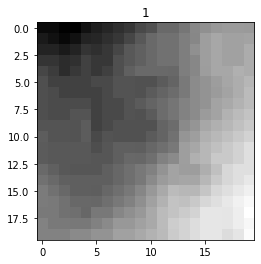

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(patches[110], cmap='gray')
ax.set_title(f"{labels[110]}")

plt.show()

# Neural networks
This code is used to train neural networks

### Loading test- and train data/labels

In [8]:
data_arr, label = np.array(patches), np.array(labels)

data_arr, label = shuffle(data_arr, label)

len_data = len(data_arr)

train_data = data_arr[:len_data//3 *2]
train_labels = label[:len_data//3 *2]

test_data = data_arr[len_data//3 *2:]
test_labels = label[len_data//3 *2:]

# Normalizeren van de images
train_data = (train_data / 255) - 0.5
test_data = (test_data / 255) - 0.5

# Reshapen van de images zodat ze de juiste dimensies hebben
train_data = np.expand_dims(train_data, axis=4)
test_data = np.expand_dims(test_data, axis=4)
print(train_data.shape)

# plt.imshow(train_data[126])

(16200, 30, 30, 3, 1)


## Creating a SVM model
This code is used to train a SVM

In [ ]:
x = len(train_data[0])
y = len(train_data[0][0])

train_data2 = np.reshape(train_data, (len(train_data), x*y) )
test_data2 = np.reshape(test_data, (len(test_data), x*y) )

print(train_data2.shape)

(16200, 400)


In [ ]:
clf = svm.SVC(gamma='scale', C=100)

clf.fit(train_data2, train_labels)

correct = 0
for i, data in enumerate(test_data2):
    res = clf.predict([data])
    if res[0] == test_labels[i]:
        correct += 1

print("Accuracy =", round((correct/len(test_data2))*100, 2) )

Accuracy = 71.37


## Creating the CNN model

### Creating the model
This code creates a CNN model with given layers so that it can be used to classify input into 2 classes

In [23]:
shape = train_data.shape
num_filters = 20
filter_size = 8
pool_size = 8


model = Sequential([
    l.Conv3D(20, (8, 8, 1), input_shape=(shape[1], shape[2], shape[3], shape[4]), strides=(3,3,3)),
    l.Dense(100, activation='relu'),
    l.MaxPooling3D(pool_size=3, padding='same'),
    l.Conv3D(20, (2, 2, 1), strides = (1,1,3)),
    # l.Dense(50, activation='sigmoid'), DIT GEEFT MEER ACCURACY
    l.Flatten(None),
    l.Dense(2, activation='softmax')
])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 8, 8, 1, 20)       1300      
                                                                 
 dense_5 (Dense)             (None, 8, 8, 1, 100)      2100      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 3, 3, 1, 100)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 2, 1, 20)       8020      
                                                                 
 flatten_2 (Flatten)         (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 162       
                                                      

### Compiling the model

In [280]:

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_data, to_categorical(train_labels), epochs=10)
validation_data = train_data, to_categorical(test_labels)

Epoch 1/10
507/507 [==============================] - 17s 33ms/step - loss: 0.5177 - accuracy: 0.7672
Epoch 2/10
507/507 [==============================] - 17s 33ms/step - loss: 0.5062 - accuracy: 0.7719
Epoch 3/10
507/507 [==============================] - 20s 40ms/step - loss: 0.5100 - accuracy: 0.7707
Epoch 4/10
507/507 [==============================] - 18s 36ms/step - loss: 0.5079 - accuracy: 0.7667
Epoch 5/10
507/507 [==============================] - 21s 41ms/step - loss: 0.5056 - accuracy: 0.7720
Epoch 6/10
507/507 [==============================] - 21s 42ms/step - loss: 0.5025 - accuracy: 0.7732
Epoch 7/10
507/507 [==============================] - 19s 37ms/step - loss: 0.4986 - accuracy: 0.7743
Epoch 8/10
507/507 [==============================] - 20s 39ms/step - loss: 0.5027 - accuracy: 0.7703
Epoch 9/10
507/507 [==============================] - 18s 35ms/step - loss: 0.4995 - accuracy: 0.7730
Epoch 10/10
507/507 [==============================] - 24s 47ms/step - loss: 0.499

In [19]:
test_loss, test_acc = model.evaluate(test_data, to_categorical(test_labels), verbose=2)
print(test_acc)


predictions = model.predict([test_data])

254/254 - 2s - loss: 0.4851 - accuracy: 0.7856 - 2s/epoch - 8ms/step
0.7855555415153503


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.38018435 0.6198156 ]


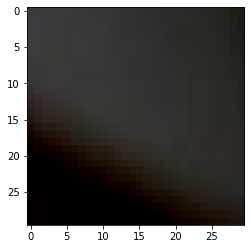

In [12]:

im = np.reshape(test_data[100], (30, 30, 3))
print(predictions[100])
plt.imshow(im)

# Hit or miss?
This code is used to generate a list to evaluate which pixel belongs to a bunny and which doesnt. And then proceed to calculate a boundary box

In [ ]:
a = np.array([1,2,3,4])
print(a.shape)
np.reshape(a, (2,2))

print(a.shape)

(4,)
(4,)


In [282]:
patch_size = 30
patches_per_image = []

im = images[71]
for x in range(patch_size//2, im.shape[0]-patch_size//2, patch_size):
    new_row = []
    for y in range(patch_size//2, im.shape[1]-patch_size//2, patch_size):

        patch = im[  x-patch_size//2 : x+patch_size//2, y-patch_size//2 : y+patch_size//2 ]
        eval_patch = np.reshape(patch, (1,30,30,3,1)) / 255 - 0.5


        res = model.predict([eval_patch])
        new_row.append(res)
    
    patches_per_image.append(new_row)


        # patches.append(patch_b)
        # labels.append(1)

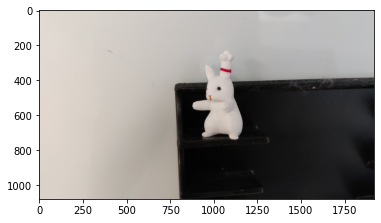

In [279]:

plt.imshow(images[71])

dat = np.array(patches_per_image)
lst = []
for x in range(dat.shape[0]):
    row = []
    for y in range(dat.shape[1]):
        # row.append( 0 if round(np.max(dat[x][y]),2) < 0.95 else round(np.max(dat[x][y]),2))
        row.append(np.argmax(dat[x][y]))
    lst.append(row)

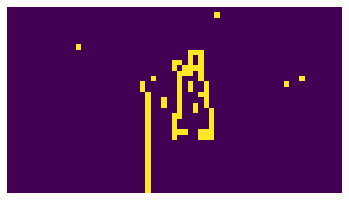

In [232]:
plt.imshow(lst)
plt.axis('off')
plt.savefig("detection.jpg")

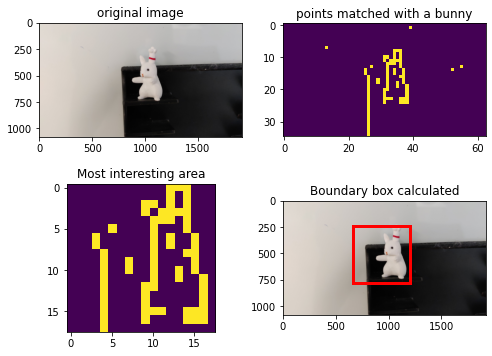

In [278]:
size = 8
hit_list = np.array(lst)

blobs = {

}

inc = 5
increase = 5
threshold = 10
for x in range(size//2, hit_list.shape[0], size):
    for y in range(size//2, hit_list.shape[1], size):
        begin_x, end_x =  x-size//2, x+size//2
        begin_y, end_y = y-size//2, y+size//2


        box = hit_list[ begin_x : end_x , begin_y : end_y]

        amount = np.count_nonzero(box == 1)
        if amount > threshold:
            while np.count_nonzero(box == 1) > threshold:
                amount = np.count_nonzero(box == 1)
                threshold = amount

                new_boxes = {
                    "top" : hit_list[  begin_x - inc : end_x, begin_y : end_y ],
                    "bottom" : hit_list[  begin_x : end_x + inc, begin_y : end_y ],
                    "left" : hit_list[  begin_x : end_x, begin_y - inc : end_y ],
                    "right" : hit_list[  begin_x : end_x, begin_y : end_y + inc ]
                }


                best_v = amount + 5
                best_b = box
                side = None
                for key, value in new_boxes.items():
                    val = np.count_nonzero(value == 1)
                    if val > best_v:
                        best_v = val
                        best_b = value
                        side = key

                if best_v == np.count_nonzero(box == 1):
                    break
                else:
                    box = best_b
                    begin_x = begin_x   - inc if side == "top" else begin_x
                    begin_y = begin_y   - inc if side == "left" else begin_y
                    end_x   = end_x     + inc if side == "bottom" else end_x
                    end_y   = end_y     + inc if side == "right" else end_y


            # substract one increase from the 'inc' variable because if done with the while loop, the 'inc' value will be one step ahead
            blobs[f'{len(blobs) +1}'] = {
                "box"   : box,
                "begin" : 
                    [
                            (begin_x - (inc - increase)) if side == "top" else begin_x,
                            (begin_y - (inc - increase)) if side == "left" else begin_y
                    ]
                , 
                            
                "end"   : 
                    [
                            (end_x + (inc - increase)) if side == "bottom" else end_x,
                            (end_y + (inc - increase)) if side == "right" else end_y
                    ]
                
            }



fig, ax = plt.subplots(2, 2, figsize=(8,6))

ax[0,0].imshow(images[71])
ax[0,0].set_title("original image")

ax[0,1].imshow(hit_list)
ax[0,1].set_title("points matched with a bunny")

ax[1,0].imshow(blobs['1']['box'])
ax[1,0].set_title("Most interesting area")

ax[1,1].imshow(images[71])
ax[1,1].set_title("Boundary box calculated")

ax[1,1].add_patch(plt.Rectangle((
                                    blobs['1']['begin'][1]*30, blobs['1']['begin'][0]*30
                                ), 
                                blobs['1']['end'][0]*30 - blobs['1']['begin'][0]*30,
                                blobs['1']['end'][1]*30 - blobs['1']['begin'][1]*30,
                                fill = False,
                                edgecolor = 'red',
                                lw = 3
                               )
                )

plt.show()

       
            


